# Movie Recommendation System based on User Input using Cosine Similarity

**University:** *International Burch University*


**Course:** *Machine Learning*

**Student:** *Benjamin Peljto*

> **Google Colab hardware specs**

In [87]:
import platform
import psutil

print("CPU:", platform.processor())
print("Machine:", platform.machine())
print("Platform:", platform.platform())
print("RAM (GB):", psutil.virtual_memory().total / 1e9)

CPU: x86_64
Machine: x86_64
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
RAM (GB): 13.605851136


In [88]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.176
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi its
bogomips	: 4400.35
clflush size	: 64
cache_alignment	: 64
address sizes

> **Dataset import and analysis**

In [89]:
import nltk
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Because of the length of the dataset, I imported it in chunks for a successful import
chunks = []
for chunk in pd.read_csv('/content/drive/MyDrive/ml_dataset/top_10000_popular_movies_tmdb.csv', chunksize=100):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df.shape

(10075, 15)

In [91]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10075 non-null  object 
 1   id                    10075 non-null  int64  
 2   title                 10075 non-null  object 
 3   release_date          10052 non-null  object 
 4   genres                10075 non-null  object 
 5   original_language     10074 non-null  object 
 6   vote_average          10074 non-null  float64
 7   vote_count            10074 non-null  float64
 8   popularity            10074 non-null  float64
 9   overview              9998 non-null   object 
 10  budget                9999 non-null   float64
 11  production_companies  9999 non-null   object 
 12  revenue               9999 non-null   float64
 13  runtime               9999 non-null   float64
 14  tagline               7383 non-null   object 
dtypes: float64(6), int6

In [92]:
print(df.columns.values)

['Unnamed: 0' 'id' 'title' 'release_date' 'genres' 'original_language'
 'vote_average' 'vote_count' 'popularity' 'overview' 'budget'
 'production_companies' 'revenue' 'runtime' 'tagline']


In [93]:
df.iloc[10]

,10
Unnamed: 0,10
id,1018494
title,Operation Seawolf
release_date,2022-10-07
genres,"['War', 'Thriller', 'Action', 'Adventure', 'My..."
original_language,English
vote_average,6.0
vote_count,41.0
popularity,1269.136
overview,"During the last days of World War II, Germany,..."


In [94]:
df.head()

,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline
0,0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0,The end of the road begins.
1,1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0,"No way back, one way out."
2,2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.8,4628.0,3394.458,"While working underground to fix a water main,...",100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0,NaN
3,3,569094,Spider-Man: Across the Spider-Verse,2023-05-31,"['Action', 'Adventure', 'Animation', 'Science ...",English,8.8,1160.0,2859.047,"After reuniting with Gwen Stacy, Brooklyn’s fu...",100000000.0,"['Columbia Pictures', 'Sony Pictures Animation...",3.135222e+08,140.0,It's how you wear the mask that matters
4,4,536437,Hypnotic,2023-05-11,"['Mystery', 'Thriller', 'Science Fiction']",English,6.5,154.0,2654.854,A detective becomes entangled in a mystery inv...,70000000.0,"['Studio 8', 'Solstice Productions', 'Ingeniou...",0.000000e+00,94.0,Control is an illusion.


*As we can see, the dataset consists of columns which are not necessary for this approach, features that we will need are the **title**, **genres**, **overview** and **tagline***

In [95]:
df.isna().sum()

,0
Unnamed: 0,0
id,0
title,0
release_date,23
genres,0
original_language,1
vote_average,1
vote_count,1
popularity,1
overview,77


*We can see here that there are ***77*** movies ***without an overview*** but it's not a problem since we can conclude similarities based on the titles and genres (both title and genres columns have no null values)*

*Also, quick notice is that there are 75 movies more than the 10 000 which author put on Kaggle (I didn't find any information why) but that's okay and I will work with all of the 10 075 movies*

*Below is a deeper analysis of the dataset and calculation of the amount of movies per genre and most popular words per genre which will affect our cosine similarity approach of recommending movies, especially when we use the BoW approach.*

In [96]:
# Firstly, because each movie in our dataset contains multiple genres, we need to break up that list into individual genres.
df_analysis = df.copy()

# In order to use the .explode() function used to divide a a row containing a list into individual rows,
# we need to convert the string representation of the list into real python list.
print(type(df_analysis["genres"][0]))
df_analysis["genres"] = df_analysis["genres"].apply(eval)
print(type(df_analysis["genres"][0]))

<class 'str'>
<class 'list'>


In [97]:
# Now when we have a list of each individual genres, we can separate them by each individual genre,
# and make separate rows for each
df_analysis = df_analysis.explode("genres")
df_analysis.head()

,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline
0,0,385687,Fast X,2023-05-17,Action,English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",652000000.0,142.0,The end of the road begins.
0,0,385687,Fast X,2023-05-17,Crime,English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",652000000.0,142.0,The end of the road begins.
0,0,385687,Fast X,2023-05-17,Thriller,English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",652000000.0,142.0,The end of the road begins.
1,1,603692,John Wick: Chapter 4,2023-03-22,Action,English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",431769198.0,170.0,"No way back, one way out."
1,1,603692,John Wick: Chapter 4,2023-03-22,Thriller,English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",431769198.0,170.0,"No way back, one way out."


*Now we can group the movies by genre and count them.*
*From earlier we concluded that we ***don't have null values on the genres field*** which is great because ***null values can mess up*** our counting. We can show the counts in a simple graph also.*

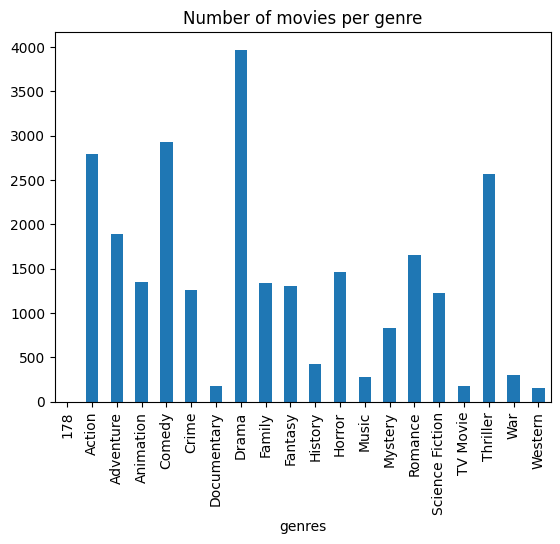

In [98]:
graph = df_analysis.groupby("genres").size().plot(kind = "bar", title = "Number of movies per genre")

*From the graph we can conclude that most of the movies belong to one of these four genres: Action, Comedy, Drama and Fantasy.*

*Because our recommendation system focuses on user's description of the wanted movie and the features that we're separating in the next section, this unbalanced score ***won't affect*** our recommendation*

*The only thing that we can conclude is that there is a ***high possibility*** that the recommended movie will have one of the above mentioned genres as a genre in it's genre list.*

Individual percentages of top 5 genres:

Drama: 15.23%
Comedy: 11.25%
Action: 10.70%
Thriller: 9.86%
Adventure: 7.26%

Combined percentage of top 5 genres:
54.30%


<Axes: title={'center': 'Percentage of movies with top 5 genres'}, xlabel='genres', ylabel='Percentage (%)'>

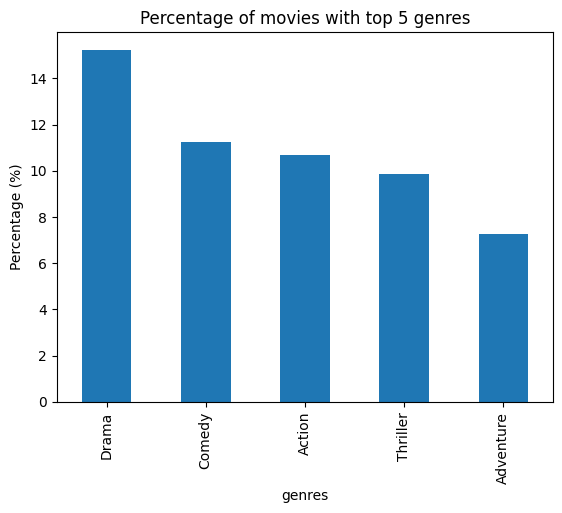

In [99]:
counts = df_analysis.groupby("genres").size()
top5 = counts.sort_values(ascending=False).head(5)

percentages_top5 = (top5 / counts.sum()) * 100

print("Individual percentages of top 5 genres:\n")
for genre, pct in percentages_top5.items():
    print(f"{genre}: {pct:.2f}%")

combined_pct = percentages_top5.sum()
print("\nCombined percentage of top 5 genres:")
print(f"{combined_pct:.2f}%")

percentages_top5.plot(
    kind='bar',
    ylabel='Percentage (%)',
    title='Percentage of movies with top 5 genres'
)

*When we talk about the factor that ***really matters*** in our recommendation system, especially when it comes to the ***BoW method***, that is what are the ***most popular words for each genre***. We can compute them as it is shown below.*

In [100]:
# Combining (concatinating) the important columns which we will later use as features
df_analysis2 = df.copy()
df_analysis2["combined"] = df["title"].str.cat(df[["genres", "overview", "tagline"]], sep="" "", na_rep="")

# Import
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

# Lowercasing, tokenizing and removing stopwords
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words("english"))

def simple_preprocess(text):
    text = text.lower()
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    tokens = word_tokenize(letters_only)
    words = [word for word in tokens if word not in stopwords]
    return ' '.join(words)

df_analysis2['processed_combined'] = df_analysis2['combined'].apply(simple_preprocess)
df_analysis2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline,combined,processed_combined
0,0,385687,Fast X,2023-05-17,"['Action', 'Crime', 'Thriller']",English,7.4,1347.0,8363.473,Over many missions and against impossible odds...,340000000.0,"['Universal Pictures', 'Original Film', 'One R...",6.520000e+08,142.0,The end of the road begins.,"Fast X['Action', 'Crime', 'Thriller']Over many...",fast x action crime thriller many missions imp...
1,1,603692,John Wick: Chapter 4,2023-03-22,"['Action', 'Thriller', 'Crime']",English,7.9,2896.0,4210.313,"With the price on his head ever increasing, Jo...",90000000.0,"['Thunder Road', '87Eleven', 'Summit Entertain...",4.317692e+08,170.0,"No way back, one way out.","John Wick: Chapter 4['Action', 'Thriller', 'Cr...",john wick chapter action thriller crime price ...
2,2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Family', 'Adventure', 'Fantasy'...",English,7.8,4628.0,3394.458,"While working underground to fix a water main,...",100000000.0,"['Universal Pictures', 'Illumination', 'Ninten...",1.308767e+09,92.0,NaN,"The Super Mario Bros. Movie['Animation', 'Fami...",super mario bros movie animation family advent...
3,3,569094,Spider-Man: Across the Spider-Verse,2023-05-31,"['Action', 'Adventure', 'Animation', 'Science ...",English,8.8,1160.0,2859.047,"After reuniting with Gwen Stacy, Brooklyn’s fu...",100000000.0,"['Columbia Pictures', 'Sony Pictures Animation...",3.135222e+08,140.0,It's how you wear the mask that matters,"Spider-Man: Across the Spider-Verse['Action', ...",spider man across spider verse action adventur...
4,4,536437,Hypnotic,2023-05-11,"['Mystery', 'Thriller', 'Science Fiction']",English,6.5,154.0,2654.854,A detective becomes entangled in a mystery inv...,70000000.0,"['Studio 8', 'Solstice Productions', 'Ingeniou...",0.000000e+00,94.0,Control is an illusion.,"Hypnotic['Mystery', 'Thriller', 'Science Ficti...",hypnotic mystery thriller science fiction dete...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10070,9995,33142,Vivah,2006-11-10,"['Romance', 'Drama']",Hindi,6.4,70.0,12.301,"Poonam, a traditionally brought-up young woman...",0.0,['Rajshri Productions'],4.000000e+06,175.0,Marriage isn't a game...,"Vivah['Romance', 'Drama']Poonam, a traditional...",vivah romance drama poonam traditionally broug...
10071,9996,9442,Dead Men Don't Wear Plaid,1982-05-21,"['Comedy', 'Mystery']",English,6.6,324.0,12.301,Juliet Forrest is convinced that the reported ...,9000000.0,"['Universal Pictures', 'Aspen Film Society']",1.819617e+07,89.0,Laugh...or I’ll blow your lips off!,"Dead Men Don't Wear Plaid['Comedy', 'Mystery']...",dead men wear plaid comedy mystery juliet forr...
10072,9997,28774,Communion,1989-11-10,"['Drama', 'Horror', 'Science Fiction', 'Thrill...",English,5.3,147.0,12.300,A novelist's wife and son see him changed by a...,5000000.0,"['The Picture Property Company', 'Allied Visio...",1.919653e+06,103.0,The true story of one man's terrifying journey...,"Communion['Drama', 'Horror', 'Science Fiction'...",communion drama horror science fiction thrille...
10073,9998,11121,Tess,1979-10-06,"['Drama', 'Romance']",English,7.0,283.0,12.300,A strong-willed peasant girl is sent by her fa...,12000000.0,"['Renn Productions', 'Timothy Burrill Producti...",2.010125e+07,186.0,She was born into a world where they called it...,"Tess['Drama', 'Romance']A strong-willed peasan...",tess drama romance strong willed peasant girl ...


In [101]:
# Since again the genres are in a list, we will need to do the same explosion of the genre list as we did earlier.
df_analysis2["genres"] = df_analysis2["genres"].apply(eval)
df_analysis2 = df_analysis2.explode("genres")

grouped_text = df_analysis2.groupby('genres')['processed_combined'].apply(' '.join)
grouped_text

,processed_combined
genres,
178,aathi thiraikalam
Action,fast x action crime thriller many missions imp...
Adventure,super mario bros movie animation family advent...
Animation,super mario bros movie animation family advent...
Comedy,super mario bros movie animation family advent...
Crime,fast x action crime thriller many missions imp...
Documentary,money shot pornhub story documentary featuring...
Drama,operation seawolf war thriller action adventur...
Family,super mario bros movie animation family advent...


In [102]:
from nltk import FreqDist

def get_most_common_words(text):
    tokens = text.split()
    freq_dist = FreqDist(tokens)
    return freq_dist.most_common(10)

# Applying the function to each genre
most_frequent_words_per_genre = grouped_text.apply(get_most_common_words)
most_frequent_words_per_genre

,processed_combined
genres,
178,"[(aathi, 1), (thiraikalam, 1)]"
Action,"[(action, 2880), (adventure, 1116), (thriller,..."
Adventure,"[(adventure, 2173), (action, 1062), (family, 8..."
Animation,"[(animation, 1361), (family, 953), (adventure,..."
Comedy,"[(comedy, 3029), (family, 1151), (adventure, 7..."
Crime,"[(crime, 1418), (thriller, 731), (action, 585)..."
Documentary,"[(documentary, 211), (life, 43), (film, 42), (..."
Drama,"[(drama, 4018), (romance, 1052), (life, 961), ..."
Family,"[(family, 1561), (adventure, 881), (animation,..."


In [103]:
summary_rows = []

for genre, words in most_frequent_words_per_genre.items():
    words_str = ', '.join([f"{word} ({count})" for word, count in words])
    summary_rows.append({'Genre': genre, '10 most frequent words': words_str})
pd.set_option('display.max_colwidth', None)
summary_df = pd.DataFrame(summary_rows)

summary_df

,Genre,10 most frequent words
0,178,"aathi (1), thiraikalam (1)"
1,Action,"action (2880), adventure (1116), thriller (1001), crime (705), drama (698), science (672), fiction (668), world (593), one (549), comedy (519)"
2,Adventure,"adventure (2173), action (1062), family (831), fantasy (636), comedy (632), animation (604), world (532), science (433), fiction (432), new (392)"
3,Animation,"animation (1361), family (953), adventure (783), comedy (538), fantasy (481), action (423), world (387), new (327), one (280), science (269)"
4,Comedy,"comedy (3029), family (1151), adventure (785), romance (785), drama (703), action (574), one (558), new (555), life (549), animation (537)"
5,Crime,"crime (1418), thriller (731), action (585), drama (583), one (283), comedy (236), life (219), mystery (210), man (193), new (184)"
6,Documentary,"documentary (211), life (43), film (42), world (39), music (38), one (38), story (32), man (28), interviews (26), making (23)"
7,Drama,"drama (4018), romance (1052), life (961), thriller (945), love (940), one (760), action (723), comedy (715), family (705), crime (682)"
8,Family,"family (1561), adventure (881), animation (801), comedy (759), fantasy (485), new (332), world (306), action (233), life (231), must (225)"
9,Fantasy,"fantasy (1331), adventure (745), family (634), action (473), animation (470), comedy (439), world (393), one (253), drama (242), new (238)"


> **Dataset reorganization and preprocessing**

*Since we do not need anything except the 4 columns which are the most relevant for the description, we are going to reorganize the dataset which is in Pandas DataFrame*

In [104]:
df = df[["title", "genres", "overview", "tagline"]]
pd.set_option('display.max_colwidth', 50)
df.head()

,title,genres,overview,tagline
0,Fast X,"['Action', 'Crime', 'Thriller']",Over many missions and against impossible odds...,The end of the road begins.
1,John Wick: Chapter 4,"['Action', 'Thriller', 'Crime']","With the price on his head ever increasing, Jo...","No way back, one way out."
2,The Super Mario Bros. Movie,"['Animation', 'Family', 'Adventure', 'Fantasy'...","While working underground to fix a water main,...",NaN
3,Spider-Man: Across the Spider-Verse,"['Action', 'Adventure', 'Animation', 'Science ...","After reuniting with Gwen Stacy, Brooklyn’s fu...",It's how you wear the mask that matters
4,Hypnotic,"['Mystery', 'Thriller', 'Science Fiction']",A detective becomes entangled in a mystery inv...,Control is an illusion.


In [105]:
df.shape

(10075, 4)

*After concluding the amount of movies we have and that there are no null values, we can continue with ***merging*** the above mentioned columns into a ***single feature column***.*

In [106]:
# Using str.cat to concatinate the relevant columns.
# I tried with '+' operator but it returns NaN as output if there is one or many columns that are NaN
df["combined_features"] = df["title"].str.cat(df[["genres", "overview", "tagline"]], sep="" "", na_rep="")
df.head()

,title,genres,overview,tagline,combined_features
0,Fast X,"['Action', 'Crime', 'Thriller']",Over many missions and against impossible odds...,The end of the road begins.,"Fast X['Action', 'Crime', 'Thriller']Over many..."
1,John Wick: Chapter 4,"['Action', 'Thriller', 'Crime']","With the price on his head ever increasing, Jo...","No way back, one way out.","John Wick: Chapter 4['Action', 'Thriller', 'Cr..."
2,The Super Mario Bros. Movie,"['Animation', 'Family', 'Adventure', 'Fantasy'...","While working underground to fix a water main,...",NaN,"The Super Mario Bros. Movie['Animation', 'Fami..."
3,Spider-Man: Across the Spider-Verse,"['Action', 'Adventure', 'Animation', 'Science ...","After reuniting with Gwen Stacy, Brooklyn’s fu...",It's how you wear the mask that matters,"Spider-Man: Across the Spider-Verse['Action', ..."
4,Hypnotic,"['Mystery', 'Thriller', 'Science Fiction']",A detective becomes entangled in a mystery inv...,Control is an illusion.,"Hypnotic['Mystery', 'Thriller', 'Science Ficti..."


*Now we can ***check*** how our column ***combined_features*** looks like for a specific movie*

In [107]:
print(df["combined_features"][0])
print("********************************************************")
print(df["combined_features"][10])

Fast X['Action', 'Crime', 'Thriller']Over many missions and against impossible odds, Dom Toretto and his family have outsmarted, out-nerved and outdriven every foe in their path. Now, they confront the most lethal opponent they've ever faced: A terrifying threat emerging from the shadows of the past who's fueled by blood revenge, and who is determined to shatter this family and destroy everything—and everyone—that Dom loves, forever.The end of the road begins.
********************************************************
Operation Seawolf['War', 'Thriller', 'Action', 'Adventure', 'Mystery', 'Science Fiction', 'Drama']During the last days of World War II, Germany, desperate for any last grasp to defeat the allied powers, looked to their last remaining weapons and soldiers. The German Navy and the last remaining U-Boats were formed together for one desperate last mission – a mission to attack the United States Homeland, known as Operation Seawolf. Captain Hans Kessler, a grizzled submarine co

*As it is shown, the dataset is already ***mostly*** cleaned. There are some problems with genres being in the square brackets and, of course, we need to clean it up and tokenize.

For cleaning the combined_features column, I'm going to ****define a function*** that ***removes everything that is not a letter***, ***tokenizes the column***, ***removes stopwords*** and finally, while trying to find the best possible match for the user's input, I will be ***lemmatizing*** the dataset column.*

In [108]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
lemmatizer = nltk.WordNetLemmatizer()
stops = set(stopwords.words("english"))

In [109]:
def cleaner_lemmatizer(text):

    # converting everything to lowercase for uniform features throughout
    text = text.lower()

    # using simple regex pattern to remove everything except letters
    letters_only = re.sub("[^a-zA-Z]", " ", text)

    # tokenize the features using built in tool in NLTK
    tokens = word_tokenize(letters_only)

    # removing stopwords and lemmatizing each of the tokens
    meaningful_lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens if word not in stops]

    # in the end, joining tokens into a string and returning it
    return ' '.join(meaningful_lemmatized_words)


*Now we can ***check the results*** of our cleaner_lemmatizer function*

In [110]:
features_uncleaned = df["combined_features"][10]
features_cleaned = cleaner_lemmatizer(df["combined_features"][10])

print(features_uncleaned)
print()
print(features_cleaned)

Operation Seawolf['War', 'Thriller', 'Action', 'Adventure', 'Mystery', 'Science Fiction', 'Drama']During the last days of World War II, Germany, desperate for any last grasp to defeat the allied powers, looked to their last remaining weapons and soldiers. The German Navy and the last remaining U-Boats were formed together for one desperate last mission – a mission to attack the United States Homeland, known as Operation Seawolf. Captain Hans Kessler, a grizzled submarine commander from both World Wars, is called into service to make one mission a success and help turn the tide of the war.Last mission to win this war.

operation seawolf war thriller action adventure mystery science fiction drama last day world war ii germany desperate last grasp defeat allied power looked last remaining weapon soldier german navy last remaining u boat formed together one desperate last mission mission attack united state homeland known operation seawolf captain han kessler grizzled submarine commander w

*The removal of unnecessary information and dataset residue ***was successful*** and the function can be now ***applied*** to the ***whole*** dataset column*

In [111]:
num_features = df["combined_features"].size
df["cleaned_features"] = df["combined_features"].apply(cleaner_lemmatizer)
print("Cleaning of the combined features column done.")

Cleaning of the combined features column done.


In [112]:
df["cleaned_features"]

,cleaned_features
0,fast x action crime thriller many mission impo...
1,john wick chapter action thriller crime price ...
2,super mario bros movie animation family advent...
3,spider man across spider verse action adventur...
4,hypnotic mystery thriller science fiction dete...
...,...
10070,vivah romance drama poonam traditionally broug...
10071,dead men wear plaid comedy mystery juliet forr...
10072,communion drama horror science fiction thrille...
10073,tess drama romance strong willed peasant girl ...


> **Computing the similarities (first way)**

*In order to compute the similarities between the user input text and the features of the movies in the dataset, we need to represent the features as numbers. There are 2 popular approaches to this and I will do them both.*

*First way is to use the ***Bag of Words or BoW*** which will represent the occurance of the words in a matrix format.*

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
import time

vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None)

start_time_bow_vectorizer = time.perf_counter()
data_features = vectorizer.fit_transform(df["cleaned_features"])
end_time_bow_vectorizer = time.perf_counter()

print("Data features shape:")
print(data_features.shape)
print()

elapsed_ms = (end_time_bow_vectorizer - start_time_bow_vectorizer) * 1000  # milliseconds
print(f"Execution time BoW vectorization: {elapsed_ms:.4f} ms")

Data features shape:
(10075, 26881)

Execution time BoW vectorization: 362.1685 ms


*With the shape function we can see the statistical numbers related to our vectorizer. There are 26867 words in the vocabulary and 10 075 rows which indicate the number of our movies. We can conclude that everything worked fine and we can continue building the function which will handle the similarity part*

In [114]:
from sklearn.metrics.pairwise import cosine_similarity


def recommend_movie(user_input, vectorizer=vectorizer, df=df):

    # doing the exact same cleaning and lemmatizing process as it is done to each of the features text
    preprocessed_input = cleaner_lemmatizer(user_input)

    # only transforming the cleaned user text because the vectorizer is already familiar with the vocabulary (fitted)
    user_vector = vectorizer.transform([preprocessed_input])

    # counting the similarities between the input vector and features vectors
    # cosine_similarity function returns the matrix of values between -1 and 1
    # those values indicate the similarity between each of the movies and user input
    similarity_scores = cosine_similarity(user_vector, data_features)

    # enumerating the similarity scores for finding the titles in the DataFrame
    similarity_scores = list(enumerate(similarity_scores[0]))

    # sorting them based on the second column - the score (first column is the index)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # slicing the first 5 recommended movies
    similarity_scores = similarity_scores[0:10]

    # making the list of all the indexes of recommended movies
    movie_indexes = [i[0] for i in similarity_scores]

    return df['title'].iloc[movie_indexes]

In [127]:
import time

def timed_recommend_movie(query):
    start = time.perf_counter()
    result = recommend_movie(query)
    end = time.perf_counter()

    elapsed_ms = (end - start) * 1000  # convert to milliseconds
    return result, elapsed_ms


# Queries
queries = [
    "animated action adventure movie",
    "a sweeping action-adventure story set in an era when villainous pirates scavenged the Caribbean seas",
    "i want to watch a romantic movie with happy end",
    "the godfather"
]

execution_times = []

# Run all queries with timing
for q in queries:
    result, time_ms = timed_recommend_movie(q)
    print("Query:", q)
    print(result)
    print(f"Execution time: {time_ms:.4f} ms")
    print("-" * 40)
    execution_times.append(time_ms)

# Compute average
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time across all queries: {average_time:.4f} ms")

Query: animated action adventure movie
3992                        An Awesome Action Movie
6478              Spider-Man, Iron Man and the Hulk
7235                                       Avatar 5
6974                  Dragon Ball: The Magic Begins
3114                           Adanis: Kutsal Kavga
6251                                         Raavan
2097         K: Seven Stories Movie 1 - R:B - Blaze
5989                                       Avatar 4
6027                                 Small Soldiers
2913    Princess Principal Crown Handler: Chapter 2
Name: title, dtype: object
Execution time: 120.1298 ms
----------------------------------------
Query: a sweeping action-adventure story set in an era when villainous pirates scavenged the Caribbean seas
4082                 The Pirates: The Last Royal Treasure
455     Pirates of the Caribbean: The Curse of the Bla...
4095                                              Hidalgo
9768      The Extraordinary Adventures of Adèle Blanc-Sec
85   

> **Computing the similarities (second way)**

*Second popular way of representing words (features) as numbers (or vectors in our case) is to compute ***word embeddings*** for each feature word.*

*Sentence transformers from HuggingFace and it's pre-trained models can represent sentences and phrases as vectors (this model will map them into ***384 dimensional dense vector space***) and can be used for tasks like clustering or semantic search.*

*Main difference between the BoW approach and word embedding approach is that Sentence transformers model capture the semantic meaning of the words and don't just count the frequency (as BoW approach does) which allows getting more relevant searches and semantic similarity.*

In [116]:
# Installing HuggingFace transformers for word embeddings

!pip install -U sentence-transformers

*After installing sentence-transformers package from HuggingFace, SentenceTransformer object needs to be initialized and set to a pre-trained ***all-MiniM-L6-v2*** model. HuggingFace used the pretrained ***microsoft/MiniLM-L12-H384-uncased*** model and fine-tuned in on a 1 billion sentence pairs dataset.*

In [117]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [118]:
start_time_embedder = time.perf_counter()
data_features_embedded = model.encode(df["cleaned_features"])
end_time_bow_vectorizer = time.perf_counter()

elapsed_ms = (end_time_bow_vectorizer - start_time_embedder) * 1000  # milliseconds
print(f"Execution time sentence transformer: {elapsed_ms:.4f} ms")

Execution time sentence transformer: 246840.4024 ms


In [119]:
data_features_embedded

array([[-0.05380038, -0.01779175, -0.01056832, ..., -0.02766327,
         0.03799922, -0.01215309],
       [-0.08245037, -0.03306179, -0.05574429, ..., -0.09413502,
        -0.01702056, -0.01427216],
       [-0.06535203, -0.02611849, -0.00691954, ...,  0.02631733,
         0.00919366, -0.03120662],
       ...,
       [-0.05032444,  0.01630733, -0.03000692, ..., -0.01488617,
        -0.04101301, -0.0638315 ],
       [-0.07302522, -0.03699595, -0.02712849, ..., -0.06493153,
         0.0092675 , -0.07568941],
       [-0.05703969,  0.02524549, -0.01093387, ..., -0.06647653,
        -0.01165811,  0.00583064]], dtype=float32)

In [120]:
#np.save('movie_embeddings.npy', data_features_embedded)

In [124]:
import numpy as np
#data_features_embedded = np.load('movie_embeddings.npy')

*Now, as with the last approach, function needs to be made that will clean and lemmatize user's input and compute cosine similarities between user input embedding and embedded features*

*Because we're using a model trained on a large amount of data, massive preprocessing won't be necessary*

In [125]:
def recommend_movie_transformers(user_input, model=model, df=df, ):

    # doing small preprocessing recommended for this model
    processed_input = user_input.strip().lower()

    # calculating the embedding of the user input using pre-trained model
    input_embedded = model.encode(processed_input)
    input_embedded = np.array(input_embedded).reshape(1, -1)
    # counting the similarities between the input vector and features vectors
    # cosine_similarity function returns the matrix of values between -1 and 1
    # those values indicate the similarity between each of the movies and user input
    similarity_scores = cosine_similarity(input_embedded, data_features_embedded)

    # enumerating the similarity scores for finding the titles in the DataFrame
    similarity_scores = list(enumerate(similarity_scores[0]))

    # sorting them based on the second column - the score (first column is the index)
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # slicing the first 5 recommended movies
    similarity_scores = similarity_scores[0:10]

    # making the list of all the indexes of recommended movies
    movie_indexes = [i[0] for i in similarity_scores]

    return df['title'].iloc[movie_indexes]

In [128]:
import time

def timed_recommend_movie_transformers(query):
    start = time.perf_counter()
    result = recommend_movie_transformers(query)
    end = time.perf_counter()

    elapsed_ms = (end - start) * 1000  # ms
    return result, elapsed_ms


# Queries
queries = [
    "animated action adventure movie",
    "a sweeping action-adventure story set in an era when villainous pirates scavenged the Caribbean seas",
    "i want to watch a romantic movie with happy end",
    "the godfather"
]

execution_times = []

# Run and time all queries
for q in queries:
    result, time_ms = timed_recommend_movie_transformers(q)
    print("Query:", q)
    print(result)
    print(f"Execution time: {time_ms:.4f} ms")
    print("-" * 40)
    execution_times.append(time_ms)

# Average time
average_time = sum(execution_times) / len(execution_times)
print(f"Average execution time across all queries: {average_time:.4f} ms")

Query: animated action adventure movie
7235                                  Avatar 5
1957                                         9
5989                                  Avatar 4
5949                           Despicable Me 4
9544                           Alpha and Omega
3795                    Fairy Tail: Dragon Cry
4902           Dragons: Gift of the Night Fury
5690                                Zootopia 2
6974             Dragon Ball: The Magic Begins
2097    K: Seven Stories Movie 1 - R:B - Blaze
Name: title, dtype: object
Execution time: 164.1795 ms
----------------------------------------
Query: a sweeping action-adventure story set in an era when villainous pirates scavenged the Caribbean seas
455      Pirates of the Caribbean: The Curse of the Bla...
4082                  The Pirates: The Last Royal Treasure
400            Pirates of the Caribbean: On Stranger Tides
829       Pirates of the Caribbean: Dead Men Tell No Tales
465               Pirates of the Caribbean: At Worl